Build a spam classifier (a more challenging exercise):  
• Download examples of spam and ham from Apache SpamAssassin’s public
datasets.  
• Unzip the datasets and familiarize yourself with the data format.  
• Split the datasets into a training set and a test set.  
• Write a data preparation pipeline to convert each email into a feature vector.  

Your preparation pipeline should transform an email into a (sparse) vector that
indicates the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.   

You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
  
Finally, try out several classifiers and see if you can build a great spam classi
fier, with both high recall and high precision.

### Download the Dataset

In [324]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset = 'abdmental01/email-spam-dedection'
download_path = './datasets'

api.dataset_download_files(dataset, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/abdmental01/email-spam-dedection


### Load Dataset

In [325]:
import os
import pandas as pd

filename = "mail_data.csv"
download_path = './datasets'

emails = pd.read_csv(os.path.join(download_path, filename))

### Basic Information

In [326]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [327]:
emails.sample(5)

,Category,Message
697,ham,"Aight, you close by or still down around alex'..."
4530,ham,"Hiya, probably coming home * weekend after next"
1870,ham,Mom wants to know where you at
4806,ham,Sorry for the delay. Yes masters
3366,ham,"Sorry, I'll call later"


In [328]:
emails[emails["Category"] == "spam"]

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [329]:
emails.rename(columns={'Category': 'Spam'}, inplace=True)
emails["Spam"] = emails["Spam"].replace({'spam': 1, 'ham': 0})

C:\Users\adars\AppData\Local\Temp\ipykernel_13552\2718226212.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emails["Spam"] = emails["Spam"].replace({'spam': 1, 'ham': 0})


In [330]:
emails

,Spam,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Train/Test Split

In [331]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(emails, test_size=0.20, random_state=42)
print(train_set.shape)
print(test_set.shape)

(4457, 2)
(1115, 2)


### EDA

([<matplotlib.axis.YTick at 0x1951d767610>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

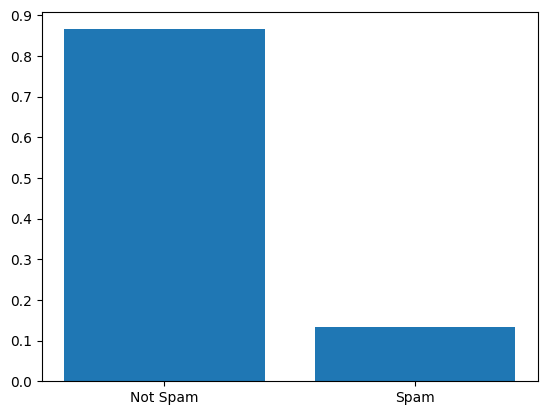

In [332]:
import matplotlib.pyplot as plt
import numpy as np

counts = emails['Spam'].value_counts()
plt.bar(counts.index, counts.values/sum(counts))
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.yticks(np.arange(0, 1, 0.1))

### Prepare data for ML algorithm 

In [333]:
X = train_set["Message"].copy()
y = train_set["Spam"].copy()

In [334]:
X

1978    Reply to win £100 weekly! Where will the 2006 ...
3989    Hello. Sort of out in town already. That . So ...
3935     How come guoyang go n tell her? Then u told her?
4078    Hey sathya till now we dint meet not even a si...
4086    Orange brings you ringtones from all time Char...
                              ...                        
3772    Hi, wlcome back, did wonder if you got eaten b...
5191                               Sorry, I'll call later
5226        Prabha..i'm soryda..realy..frm heart i'm sory
5390                           Nt joking seriously i told
860               Did he just say somebody is named tampa
Name: Message, Length: 4457, dtype: object

Custom transformers for various purposes

In [335]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
import re

class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True):
        self.lowercase = lowercase

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.lowercase:
            return [text.lower() for text in X]
        else:
            return X

class NumberReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, keep_numbers=None):
        self.keep_numbers = keep_numbers
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess_numbers(text) for text in X]
    
    def _preprocess_numbers(self, text):
        if self.keep_numbers:
            keep_pattern = '|'.join(map(str, self.keep_numbers))
            pattern = r'\b(?!(' + keep_pattern + r')\b)\d+\b'
        else:
            pattern = r'\b\d+\b'

        text = re.sub(pattern, 'NUMBER', text)

        return text
    
class URLReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace=True):
        self.replace = replace
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.replace:
            url_pattern = r'https?://\S+|www\.\S+'
            return [re.sub(url_pattern, 'URL', text) for text in X]
        else:
            return X
    
class PunctuationReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace=True):
        self.replace=replace

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.replace:
            punctuation_pattern = r'[^\w\s]'
            return [re.sub(punctuation_pattern, '', text) for text in X]
        else:
            return X
        
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stem=True):
        self.stem = stem
        self.stemmer = PorterStemmer()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.stem:
            return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]
        else:
            return X
        
email_preprocessor = Pipeline([
    ('lowercase_transformer', LowercaseTransformer(lowercase=True)),
    ('number_replacer', NumberReplacer(keep_numbers=[2, 4])),
    ('url_replacer', URLReplacer(replace=True)),
    ('punctuation_replacer', PunctuationReplacer(replace=True)),
    ('stemmer', Stemmer(stem=True)),
])

email_vectorizer = Pipeline([
    ('preprocessor', email_preprocessor),
    ('vectorizer', CountVectorizer())
])

In [336]:
X_vector = email_vectorizer.fit_transform(X)

In [337]:
X_vector.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(4457, 6677))

### Training The Model

In [338]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


model_svc = SVC()
model_linear_svc = LinearSVC()
model_logistic_regression = LogisticRegression()
model_multinomial_nb = MultinomialNB()

model_svc.fit(X_vector, y)
model_linear_svc.fit(X_vector, y)
model_logistic_regression.fit(X_vector, y)
model_multinomial_nb.fit(X_vector, y)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [339]:
from sklearn.model_selection import cross_val_score

scores_svc = cross_val_score(model_svc, X_vector, y, cv=10, scoring="accuracy")
scores_linear_svc = cross_val_score(model_linear_svc, X_vector, y, cv=10, scoring="accuracy")
scores_logistic_regression = cross_val_score(model_logistic_regression, X_vector, y, cv=10, scoring="accuracy")
scores_multinomial_nb = cross_val_score(model_multinomial_nb, X_vector, y, cv=10, scoring="accuracy")

d:\programming\machine_learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [340]:
print(sum(scores_svc) / 10)
print(sum(scores_linear_svc) / 10)
print(sum(scores_logistic_regression) / 10)
print(sum(scores_multinomial_nb) / 10)

0.9786814128079809
0.9854149241698996
0.9836201944878317
0.9712833173779412


In [341]:
from sklearn.model_selection import cross_val_predict

pred_svc = cross_val_predict(model_svc, X_vector, y, cv=10)
pred_linear_svc = cross_val_predict(model_linear_svc, X_vector, y, cv=10)
pred_logistic_regression = cross_val_predict(model_logistic_regression, X_vector, y, cv=10)
pred_multinomial_nb = cross_val_predict(model_multinomial_nb, X_vector, y, cv=10)

In [342]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y, pred_svc), recall_score(y, pred_svc), f1_score(y, pred_svc))
print(precision_score(y, pred_linear_svc), recall_score(y, pred_linear_svc), f1_score(y, pred_linear_svc))
print(precision_score(y, pred_logistic_regression), recall_score(y, pred_logistic_regression), f1_score(y, pred_logistic_regression))
print(precision_score(y, pred_multinomial_nb), recall_score(y, pred_multinomial_nb), f1_score(y, pred_multinomial_nb))

0.9808795411089866 0.8578595317725752 0.9152542372881356
0.9750445632798574 0.9147157190635451 0.9439171699741156
0.987012987012987 0.8896321070234113 0.9357959542656112
0.8593272171253823 0.939799331103679 0.8977635782747604


linearSVC has highest accuracy, highest f1 score, and perfect balance of precision and recall.
Hence we choose linear svc.

### Hyperparameter Tuning

In [343]:
from sklearn.model_selection import GridSearchCV

model = LinearSVC(random_state=42)

param_grid = {
    'C': np.logspace(-3, 3, 7),        # 0.001, 0.01, 0.1, 1, 10, 100, 1000
    'max_iter': [1000, 2000, 5000],    # ensures convergence
    'dual': [True, False],                    # for n_samples > n_features (text data)
    'loss': ['squared_hinge'],          # more stable, faster than 'hinge'
    'tol': [1e-4, 1e-3, 1e-2]          # stopping criteria tolerance
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_vector, y)

results_df = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


In [344]:
results_df.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_loss,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
68,0.037331,0.005824,0.009799,0.003448,1.0,False,squared_hinge,2000,0.0100,"{'C': 1.0, 'dual': False, 'loss': 'squared_hin...",0.966102,0.949153,0.938053,0.922414,0.918919,0.938928,0.017417,1
65,0.039182,0.002573,0.014848,0.002518,1.0,False,squared_hinge,1000,0.0100,"{'C': 1.0, 'dual': False, 'loss': 'squared_hin...",0.966102,0.949153,0.938053,0.922414,0.918919,0.938928,0.017417,1
71,0.030552,0.001986,0.007944,0.000388,1.0,False,squared_hinge,5000,0.0100,"{'C': 1.0, 'dual': False, 'loss': 'squared_hin...",0.966102,0.949153,0.938053,0.922414,0.918919,0.938928,0.017417,1
81,0.324958,0.034713,0.008494,0.000793,10.0,False,squared_hinge,1000,0.0001,"{'C': 10.0, 'dual': False, 'loss': 'squared_hi...",0.970464,0.949153,0.938053,0.919149,0.914027,0.938169,0.020534,4
87,0.294912,0.050769,0.007591,0.001346,10.0,False,squared_hinge,5000,0.0001,"{'C': 10.0, 'dual': False, 'loss': 'squared_hi...",0.970464,0.949153,0.938053,0.919149,0.914027,0.938169,0.020534,4


In [345]:
model_best = LinearSVC(tol=0.1, dual=False)
model_best.fit(X_vector, y)

,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.1
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [346]:
scores_accuracy = cross_val_score(model_best, X_vector, y, cv=10, scoring="accuracy")
scores_precision = cross_val_score(model_best, X_vector, y, cv=10, scoring="precision")
scores_recall = cross_val_score(model_best, X_vector, y, cv=10, scoring="recall")
scores_f1 = cross_val_score(model_best, X_vector, y, cv=10, scoring="f1")

print(sum(scores_accuracy) / 10)
print(sum(scores_precision) / 10)
print(sum(scores_recall) / 10)
print(sum(scores_f1) / 10)

0.9865365042575702
0.9841415713872029
0.9145480225988699
0.9473879231784463


### Test Set

In [347]:
X_test = test_set["Message"]
y_test = test_set["Spam"]

X_test_vector = email_vectorizer.transform(X_test)

d:\programming\machine_learning\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [348]:
y_pred = model_best.predict(X_test_vector)

In [349]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(accuracy)
print(precision)
print(recall)
print(f1)

0.9874439461883409
0.9856115107913669
0.9194630872483222
0.9513888888888888


Lets check accuracy on spam alone

In [350]:
X_test_spam = test_set[test_set["Spam"] == 1]["Message"]
X_test_spam.loc[944] = test_set.loc[944]["Message"]

y_test_spam = test_set[test_set["Spam"] == 1]["Spam"]
y_test_spam.loc[944] = 0

C:\Users\adars\AppData\Local\Temp\ipykernel_13552\261708928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_spam.loc[944] = test_set.loc[944]["Message"]
C:\Users\adars\AppData\Local\Temp\ipykernel_13552\261708928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_spam.loc[944] = 0


In [351]:
X_test_spam_vector = email_vectorizer.transform(X_test_spam)

d:\programming\machine_learning\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [353]:
y_pred = model_best.predict(X_test_spam_vector)

In [354]:
from sklearn.metrics import accuracy_score
accuracy_spam = accuracy_score(y_test_spam, y_pred)

print(accuracy_spam)

0.92


Our model gave precision, recall and f1 score 0.9856, 0.9194, 0.9513 respectively on test set.
It gave an accuracy of 92% on detecting spam email on test set.